In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

# 1. Definição do caminho do arquivo
arquivo = '/content/drive/MyDrive/Trabalho final paula/PM_Diario_Dracena_SP.csv'

# 2. Carregamento e Preparação Inicial
try:
    df_dracena = pd.read_csv(arquivo, sep=',', index_col=0, parse_dates=True)
except FileNotFoundError:
    print(f"Erro: O arquivo não foi encontrado no caminho: {arquivo}")
    # Retorna para evitar erros se o arquivo real não estiver acessível
    raise

# 3. Limpeza do Índice (Remoção do Timezone)
if df_dracena.index.tz is not None:
    df_dracena.index = df_dracena.index.tz_localize(None)

# 4. Renomeação das Colunas para Nomes Mais Simples
colunas_para_renomear = {
    'PM2.5 (µg/m³)': 'PM25',
    'PM10 (µg/m³)': 'PM10'
}
df_dracena.rename(columns=colunas_para_renomear, inplace=True)

# 5. Agregação de Horário para Diário (Resample)
df_diario = df_dracena[['PM25', 'PM10']].resample('D').mean()

# 6. Visualização do Novo DataFrame Diário
print("--- DataFrame Original (Horário) ---")
print(df_dracena.head())
print("\n--- DataFrame Resultante (Diário) ---")
print(df_diario.head())

# Salvando o novo DataFrame diário (opcional)
df_diario.to_csv('PM_Medias_Diarias_Dracena_SP.csv')

--- DataFrame Original (Horário) ---
                       PM25     PM10
2018-01-01 00:00:00  49.000  109.702
2018-01-01 01:00:00  43.967   96.554
2018-01-01 02:00:00  38.935   83.405
2018-01-01 03:00:00  33.902   70.257
2018-01-01 04:00:00  27.812   57.807

--- DataFrame Resultante (Diário) ---
                 PM25       PM10
2018-01-01  18.041625  43.423292
2018-01-02  14.044542  37.196083
2018-01-03   7.060583  18.316875
2018-01-04   4.888083   9.256458
2018-01-05   8.467542  24.253542


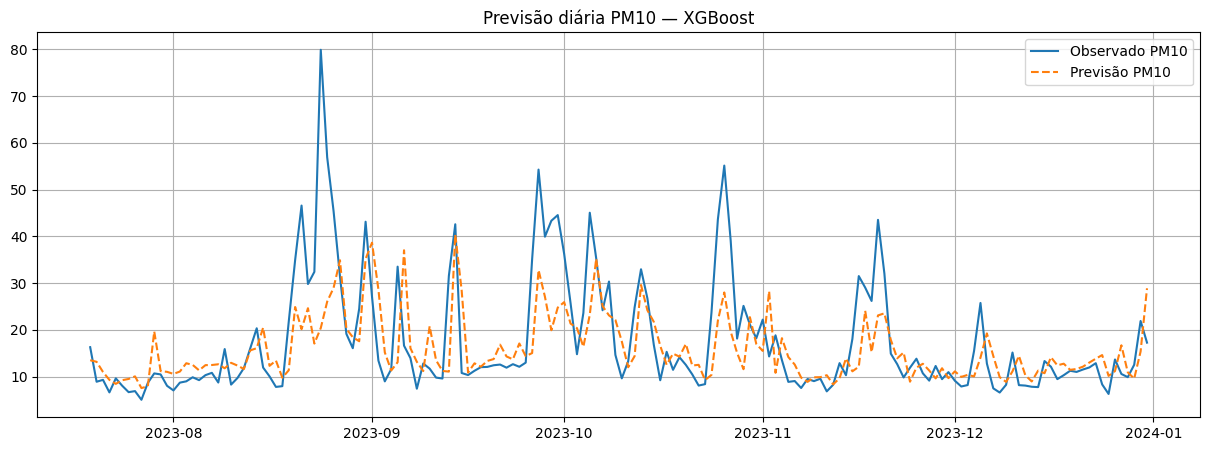

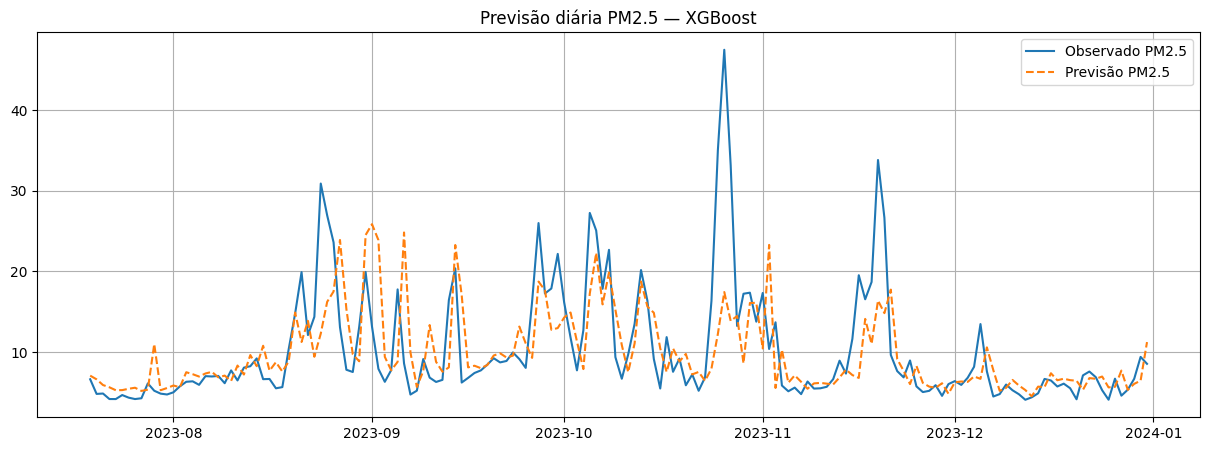

In [ ]:
#@title Implementação XGBoost - média diária
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ==========================================================
# Preparação das FEATURES
# ==========================================================
df = df_diario.copy()

df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['weekday'] = df.index.weekday

# Lags para PM10
df['lag1_10'] = df['PM10'].shift(1)
df['lag2_10'] = df['PM10'].shift(2)
df['lag7_10'] = df['PM10'].shift(7)

# Lags para PM2.5
df['lag1_25'] = df['PM25'].shift(1)
df['lag2_25'] = df['PM25'].shift(2)
df['lag7_25'] = df['PM25'].shift(7)

df.dropna(inplace=True)

# Separar treino e teste
train = df.loc[:'2023-07-18']
test  = df.loc['2023-07-19':]

# ==========================================================
# 1) MODELO PARA PM10
# ==========================================================
X_train_10 = train.drop(['PM10','PM25'], axis=1)
y_train_10 = train['PM10']

X_test_10  = test.drop(['PM10','PM25'], axis=1)

model_10 = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model_10.fit(X_train_10, y_train_10)
forecast_10 = model_10.predict(X_test_10)

# ==========================================================
# 2) MODELO PARA PM2.5
# ==========================================================
X_train_25 = train.drop(['PM10','PM25'], axis=1)
y_train_25 = train['PM25']

X_test_25  = test.drop(['PM10','PM25'], axis=1)

model_25 = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model_25.fit(X_train_25, y_train_25)
forecast_25 = model_25.predict(X_test_25)

# ==========================================================
# PLOTS
# ==========================================================

plt.figure(figsize=(15,5))
plt.plot(test.index, test['PM10'], label='Observado PM10')
plt.plot(test.index, forecast_10, '--', label='Previsão PM10')
plt.title('Previsão diária PM10 — XGBoost')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test.index, test['PM25'], label='Observado PM2.5')
plt.plot(test.index, forecast_25, '--', label='Previsão PM2.5')
plt.title('Previsão diária PM2.5 — XGBoost')
plt.legend()
plt.grid()
plt.show()



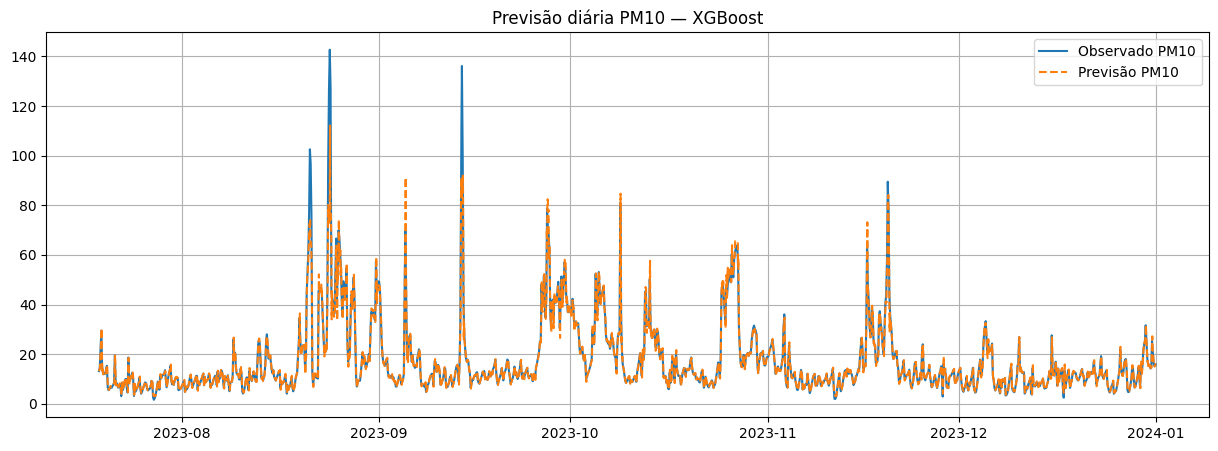

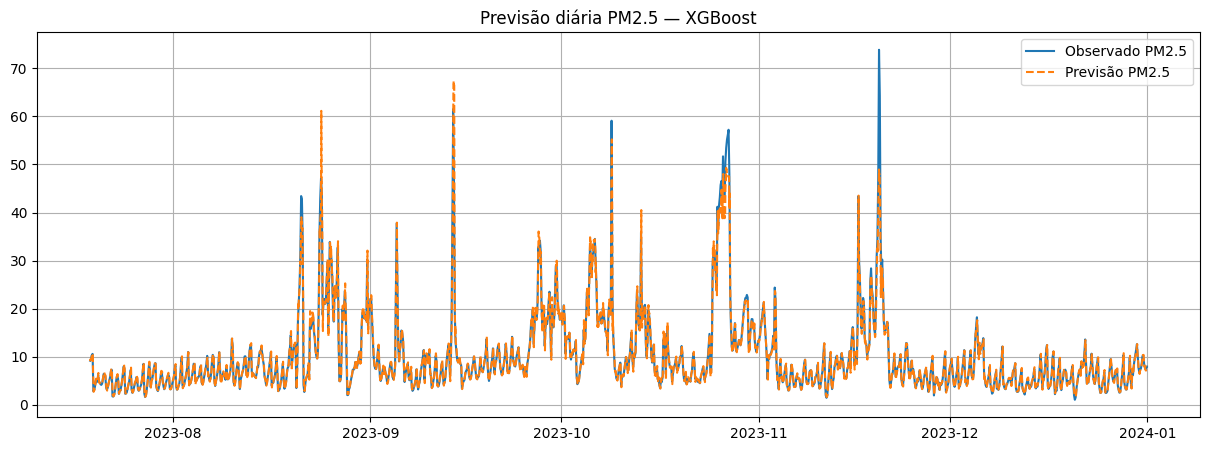

In [ ]:
#@title Implementação XGBoost - Dados horários
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# ==========================================================
# Preparação das FEATURES
# ==========================================================
df = df_dracena.copy()

df['dayofyear'] = df.index.dayofyear
df['month'] = df.index.month
df['weekday'] = df.index.weekday

# Lags para PM10
df['lag1_10'] = df['PM10'].shift(1)
df['lag2_10'] = df['PM10'].shift(2)
df['lag7_10'] = df['PM10'].shift(7)

# Lags para PM2.5
df['lag1_25'] = df['PM25'].shift(1)
df['lag2_25'] = df['PM25'].shift(2)
df['lag7_25'] = df['PM25'].shift(7)

df.dropna(inplace=True)

# Separar treino e teste
train = df.loc[:'2023-07-18']
test  = df.loc['2023-07-19':]

# ==========================================================
# 1) MODELO PARA PM10
# ==========================================================
X_train_10 = train.drop(['PM10','PM25'], axis=1)
y_train_10 = train['PM10']

X_test_10  = test.drop(['PM10','PM25'], axis=1)

model_10 = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model_10.fit(X_train_10, y_train_10)
forecast_10 = model_10.predict(X_test_10)

# ==========================================================
# 2) MODELO PARA PM2.5
# ==========================================================
X_train_25 = train.drop(['PM10','PM25'], axis=1)
y_train_25 = train['PM25']

X_test_25  = test.drop(['PM10','PM25'], axis=1)

model_25 = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror'
)

model_25.fit(X_train_25, y_train_25)
forecast_25 = model_25.predict(X_test_25)

# ==========================================================
# PLOTS
# ==========================================================

plt.figure(figsize=(15,5))
plt.plot(test.index, test['PM10'], label='Observado PM10')
plt.plot(test.index, forecast_10, '--', label='Previsão PM10')
plt.title('Previsão diária PM10 — XGBoost')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(15,5))
plt.plot(test.index, test['PM25'], label='Observado PM2.5')
plt.plot(test.index, forecast_25, '--', label='Previsão PM2.5')
plt.title('Previsão diária PM2.5 — XGBoost')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0088
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0055
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0067
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0067
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0055
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062
Epoch 10/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0063
Epoch 11/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0053
Epoch 12/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0062
Epoch 13/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0058
Epoch 14/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0063
Epoch 15/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - l

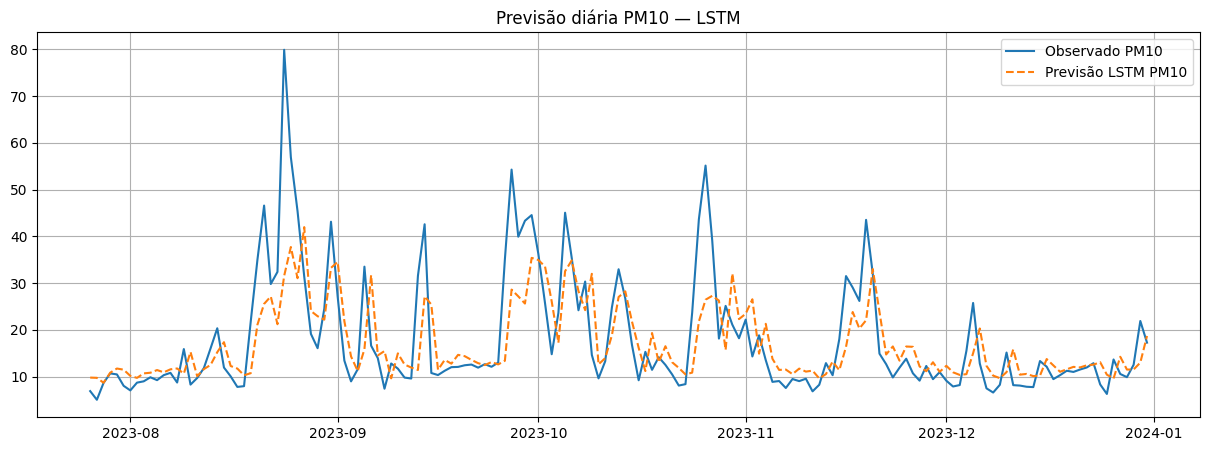

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0070
Epoch 2/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051
Epoch 3/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0049
Epoch 4/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0052
Epoch 5/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033
Epoch 6/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0050
Epoch 7/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0040
Epoch 8/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0035
Epoch 9/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0038
Epoch 10/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0042
Epoch 11/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0041
Epoch 12/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039
Epoch 13/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0044
Epoch 14/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0031
Epoch 15/50
127/127 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.00

1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


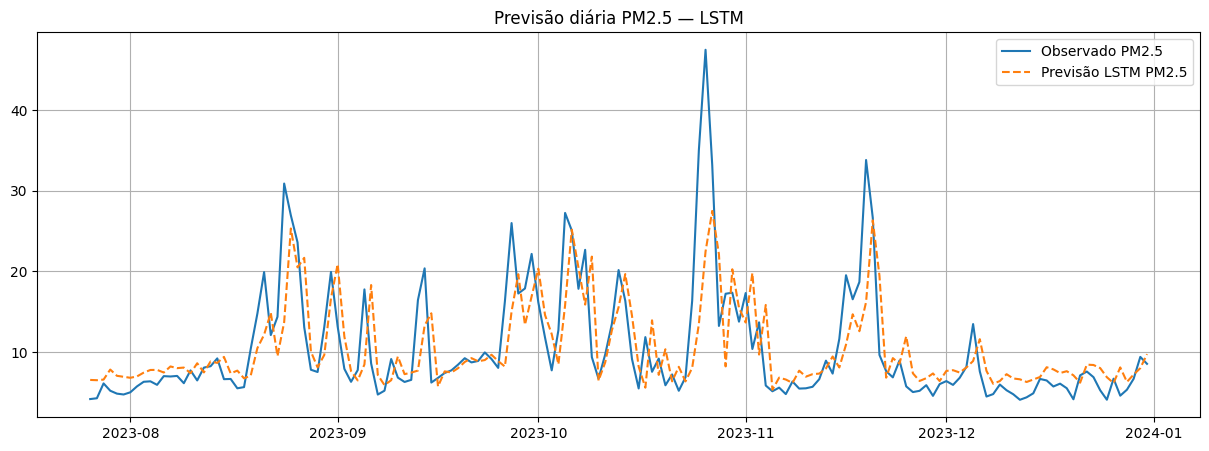

In [ ]:
#@title Implementação LSTM - média diária
# =============================================================
# BIBLIOTECAS
# =============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


# =============================================================
# 1. PREPARAÇÃO DA BASE
# =============================================================
df = df_diario.copy()
df = df[['PM10', 'PM25']]   # garantir ordem das colunas
df = df.dropna()

# Separação treino/teste
train = df.loc[:'2023-07-18']
test  = df.loc['2023-07-19':]


# =============================================================
# 2. NORMALIZAÇÃO
# =============================================================
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled  = scaler.transform(test)


# =============================================================
# 3. FUNÇÃO PARA CRIAR SEQUÊNCIAS
# =============================================================
def create_sequences(data, window=7):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i, 0])   # saída = primeira coluna (PM10)
    return np.array(X), np.array(y)


WINDOW = 7  # usar 7 dias de histórico


# =============================================================
# 4. MODELO LSTM PARA PM10
# =============================================================

# Criar janelas apenas com a coluna PM10 (índice 0)
X_train_10, y_train_10 = create_sequences(train_scaled[:, [0]], WINDOW)
X_test_10,  y_test_10  = create_sequences(test_scaled[:, [0]], WINDOW)

# Definir rede
model_10 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(WINDOW, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_10.compile(loss='mse', optimizer='adam')

# Treinamento
history_10 = model_10.fit(
    X_train_10, y_train_10,
    epochs=50, batch_size=16, verbose=1
)

# Previsão
pred_10 = model_10.predict(X_test_10)


# =============================================================
# 5. INVERTER NORMALIZAÇÃO (PM10)
# =============================================================
# Criar vetor fake para PM25 para poder inverter o scale
pred_full_10 = np.concatenate([pred_10, np.zeros((len(pred_10), 1))], axis=1)
true_10 = scaler.inverse_transform(pred_full_10)[:, 0]

obs_10 = test['PM10'].iloc[WINDOW:].values
idx_10 = test.index[WINDOW:]


# =============================================================
# 6. PLOT PM10
# =============================================================
plt.figure(figsize=(15,5))
plt.plot(idx_10, obs_10, label="Observado PM10")
plt.plot(idx_10, true_10, '--', label="Previsão LSTM PM10")
plt.title("Previsão diária PM10 — LSTM")
plt.legend()
plt.grid()
plt.show()


# =============================================================
# 7. MODELO LSTM PARA PM2.5
# =============================================================

# Criar janelas apenas com a coluna PM2.5 (índice 1)
X_train_25, y_train_25 = create_sequences(train_scaled[:, [1]], WINDOW)
X_test_25,  y_test_25  = create_sequences(test_scaled[:, [1]], WINDOW)

# Definir rede
model_25 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(WINDOW, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

model_25.compile(loss='mse', optimizer='adam')

# Treinamento
history_25 = model_25.fit(
    X_train_25, y_train_25,
    epochs=50, batch_size=16, verbose=1
)

# Previsão
pred_25 = model_25.predict(X_test_25)


# =============================================================
# 8. INVERTER NORMALIZAÇÃO (PM2.5)
# =============================================================
# Criar vetor fake para PM10 agora
pred_full_25 = np.concatenate([np.zeros((len(pred_25), 1)), pred_25], axis=1)
true_25 = scaler.inverse_transform(pred_full_25)[:, 1]

obs_25 = test['PM25'].iloc[WINDOW:].values
idx_25 = test.index[WINDOW:]


# =============================================================
# 9. PLOT PM2.5
# =============================================================
plt.figure(figsize=(15,5))
plt.plot(idx_25, obs_25, label="Observado PM2.5")
plt.plot(idx_25, true_25, '--', label="Previsão LSTM PM2.5")
plt.title("Previsão diária PM2.5 — LSTM")
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


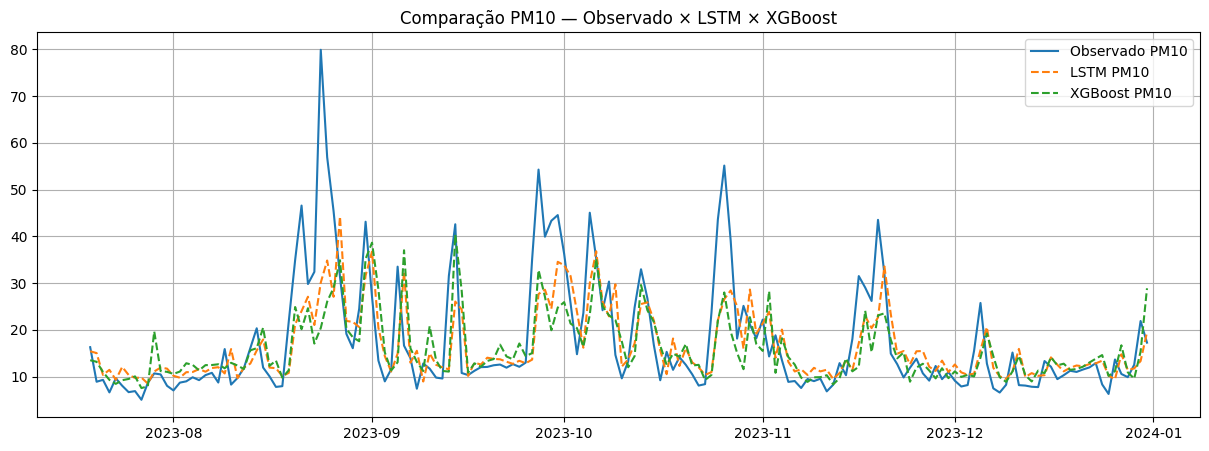

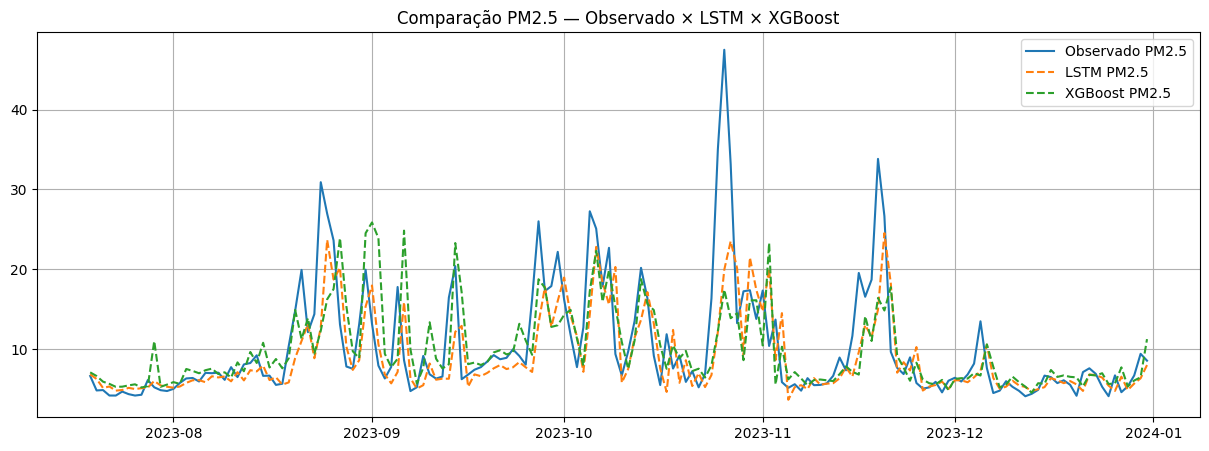

Métricas salvas em 'metricas_completas.csv'.


In [ ]:
#@title LSTM X XGBoost - Comparativo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# =============================================================
# 1. PREPARAÇÃO DA BASE
# =============================================================
df = df_diario.copy()
df = df[['PM10', 'PM25']].dropna()

train = df.loc[:'2023-07-18']
test  = df.loc['2023-07-19':]

# =============================================================
# 2. NORMALIZAÇÃO (AJUSTAR SCALER NO DATAFRAME COMPLETO)
#    -> isto evita mismatch entre escala de treino e escala de teste
# =============================================================
scaler = MinMaxScaler()
scaled_full = scaler.fit_transform(df)   # fit no dataset completo (2 colunas)

# para conveniência, criar arrays 1D por variável
series_full_10 = scaled_full[:, 0].reshape(-1, 1)  # PM10 escalado (full)
series_full_25 = scaled_full[:, 1].reshape(-1, 1)  # PM25 escalado (full)

# =============================================================
# 3. FUNÇÃO PARA JANELAS (LSTM) - 1D
# =============================================================
def create_sequences_1d(data_1d, window=7):
    X, y = [], []
    N = len(data_1d)
    for i in range(window, N):
        X.append(data_1d[i-window:i].reshape(window, 1))
        y.append(data_1d[i, 0])
    X = np.array(X)  # shape (n_samples, window, 1)
    y = np.array(y)  # shape (n_samples,)
    return X, y

WINDOW = 7

# =============================================================
# 4. Criar sequências completas (full) e dividir em treino/test
#    de forma alinhada com o índice 'test' (garante mesmo número de pontos)
# =============================================================
n_test = len(test)  # número de dias do período de previsão (ex.: 166)

# PM10
X_full_10, y_full_10 = create_sequences_1d(series_full_10, WINDOW)
# dividir: últimos n_test amostras -> teste
X_train_10 = X_full_10[:-n_test]
y_train_10 = y_full_10[:-n_test]
X_test_10  = X_full_10[-n_test:]
y_test_10  = y_full_10[-n_test:]

# PM25
X_full_25, y_full_25 = create_sequences_1d(series_full_25, WINDOW)
X_train_25 = X_full_25[:-n_test]
y_train_25 = y_full_25[:-n_test]
X_test_25  = X_full_25[-n_test:]
y_test_25  = y_full_25[-n_test:]

# =============================================================
# 5. LSTM — PM10 (treinar com X_train_10 e predizer X_test_10)
# =============================================================
model_10 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(WINDOW, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_10.compile(loss='mse', optimizer='adam')

history_10 = model_10.fit(X_train_10, y_train_10, epochs=50, batch_size=16, verbose=0)

pred_scaled_10 = model_10.predict(X_test_10)  # previsões escaladas (shape n_test x 1)

# salvar treino/loss (opcional)
pd.DataFrame(X_train_10.reshape(X_train_10.shape[0], -1)).to_csv("X_train_LSTM_PM10.csv", index=False)
pd.DataFrame(y_train_10, columns=["y_train_10"]).to_csv("y_train_LSTM_PM10.csv", index=False)
pd.DataFrame(history_10.history['loss'], columns=["loss"]).to_csv("loss_LSTM_PM10.csv", index=False)


# =============================================================
# 6. Inverter escala PM10 (usar scaler que foi fit em df inteiro)
# =============================================================
# Para inverter MinMaxScaler que foi fit em 2 colunas, criamos array 2-colunas:
dummy_10 = np.zeros((len(pred_scaled_10), 2))
dummy_10[:, 0] = pred_scaled_10[:, 0]        # colocar PM10 previsto na coluna 0
pred_inv_10 = scaler.inverse_transform(dummy_10)[:, 0]  # valores em escala original

# Observado (completo) para o período de teste (sem offset — temos n_test pontos)
obs_10 = test['PM10'].values
idx_10 = test.index

# salvar previsões LSTM PM10 em CSV (alinhadas com idx_10)
pd.DataFrame({"PM10_LSTM": pred_inv_10}, index=idx_10).to_csv("pred_LSTM_PM10.csv")


# =============================================================
# 7. LSTM — PM2.5
# =============================================================
model_25 = Sequential([
    LSTM(64, return_sequences=False, input_shape=(WINDOW, 1)),
    Dense(32, activation='relu'),
    Dense(1)
])
model_25.compile(loss='mse', optimizer='adam')

history_25 = model_25.fit(X_train_25, y_train_25, epochs=50, batch_size=16, verbose=0)

pred_scaled_25 = model_25.predict(X_test_25)

# salvar treino/loss (opcional)
pd.DataFrame(X_train_25.reshape(X_train_25.shape[0], -1)).to_csv("X_train_LSTM_PM25.csv", index=False)
pd.DataFrame(y_train_25, columns=["y_train_25"]).to_csv("y_train_LSTM_PM25.csv", index=False)
pd.DataFrame(history_25.history['loss'], columns=["loss"]).to_csv("loss_LSTM_PM25.csv", index=False)

# inverter escala PM25
dummy_25 = np.zeros((len(pred_scaled_25), 2))
dummy_25[:, 1] = pred_scaled_25[:, 0]        # colocar PM25 previsto na coluna 1
pred_inv_25 = scaler.inverse_transform(dummy_25)[:, 1]

obs_25 = test['PM25'].values
idx_25 = test.index

pd.DataFrame({"PM25_LSTM": pred_inv_25}, index=idx_25).to_csv("pred_LSTM_PM25.csv")


# =============================================================
# 8. XGBOOST — FEATURES (sem alteração)
# =============================================================
df_xgb = df_diario.copy()

df_xgb['dayofyear'] = df_xgb.index.dayofyear
df_xgb['month'] = df_xgb.index.month
df_xgb['weekday'] = df_xgb.index.weekday

df_xgb['lag1_10'] = df_xgb['PM10'].shift(1)
df_xgb['lag2_10'] = df_xgb['PM10'].shift(2)
df_xgb['lag7_10'] = df_xgb['PM10'].shift(7)

df_xgb['lag1_25'] = df_xgb['PM25'].shift(1)
df_xgb['lag2_25'] = df_xgb['PM25'].shift(2)
df_xgb['lag7_25'] = df_xgb['PM25'].shift(7)

df_xgb.dropna(inplace=True)

train_xgb = df_xgb.loc[:'2023-07-18']
test_xgb  = df_xgb.loc['2023-07-19':]


# =============================================================
# 9. XGBOOST — PM10
# =============================================================
X_train_xgb_10 = train_xgb.drop(['PM10','PM25'], axis=1)
y_train_xgb_10 = train_xgb['PM10']

X_test_xgb_10  = test_xgb.drop(['PM10','PM25'], axis=1)

model_xgb_10 = XGBRegressor(
    n_estimators=300, learning_rate=0.05,
    max_depth=5, subsample=0.8, colsample_bytree=0.8,
    objective='reg:squarederror'
)

model_xgb_10.fit(X_train_xgb_10, y_train_xgb_10)
forecast_xgb_10 = model_xgb_10.predict(X_test_xgb_10)

pd.DataFrame({"PM10_XGB": forecast_xgb_10}, index=test_xgb.index).to_csv("pred_XGB_PM10.csv")
pd.DataFrame(X_train_xgb_10).assign(PM10=y_train_xgb_10).to_csv("treino_XGBoost_PM10.csv", index=False)


# =============================================================
# 10. XGBOOST — PM2.5
# =============================================================
X_train_xgb_25 = train_xgb.drop(['PM10','PM25'], axis=1)
y_train_xgb_25 = train_xgb['PM25']

X_test_xgb_25  = test_xgb.drop(['PM10','PM25'], axis=1)

model_xgb_25 = XGBRegressor(
    n_estimators=300, learning_rate=0.05,
    max_depth=5, subsample=0.8, colsample_bytree=0.8,
    objective='reg:squarederror'
)

model_xgb_25.fit(X_train_xgb_25, y_train_xgb_25)
forecast_xgb_25 = model_xgb_25.predict(X_test_xgb_25)

pd.DataFrame({"PM25_XGB": forecast_xgb_25}, index=test_xgb.index).to_csv("pred_XGB_PM25.csv")
pd.DataFrame(X_train_xgb_25).assign(PM25=y_train_xgb_25).to_csv("treino_XGBoost_PM25.csv", index=False)


# =============================================================
# 11. GRÁFICOS COMPARADOS
# =============================================================
plt.figure(figsize=(15,5))
plt.plot(idx_10, obs_10, label="Observado PM10")
plt.plot(idx_10, pred_inv_10, '--', label="LSTM PM10")
plt.plot(test_xgb.index, forecast_xgb_10, '--', label="XGBoost PM10")
plt.title("Comparação PM10 — Observado × LSTM × XGBoost")
plt.legend(); plt.grid(); plt.show()

plt.figure(figsize=(15,5))
plt.plot(idx_25, obs_25, label="Observado PM2.5")
plt.plot(idx_25, pred_inv_25, '--', label="LSTM PM2.5")
plt.plot(test_xgb.index, forecast_xgb_25, '--', label="XGBoost PM2.5")
plt.title("Comparação PM2.5 — Observado × LSTM × XGBoost")
plt.legend(); plt.grid(); plt.show()


# =============================================================
# 12. MÉTRICAS NORMALIZADAS (corrigido para calcular RMSE)
# =============================================================
def normalize_error(y_true, y_pred):
    return mean_absolute_error(
        (y_true - y_true.min())/(y_true.max()-y_true.min()),
        (y_pred - y_true.min())/(y_true.max()-y_true.min())
    )

# calcular MAE e RMSE (RMSE = sqrt(MSE) para compatibilidade)
mae_lstm_10 = mean_absolute_error(obs_10, pred_inv_10)
mae_xgb_10  = mean_absolute_error(obs_10, forecast_xgb_10)
mae_lstm_25 = mean_absolute_error(obs_25, pred_inv_25)
mae_xgb_25  = mean_absolute_error(obs_25, forecast_xgb_25)

rmse_lstm_10 = np.sqrt(mean_squared_error(obs_10, pred_inv_10))
rmse_xgb_10  = np.sqrt(mean_squared_error(obs_10, forecast_xgb_10))
rmse_lstm_25 = np.sqrt(mean_squared_error(obs_25, pred_inv_25))
rmse_xgb_25  = np.sqrt(mean_squared_error(obs_25, forecast_xgb_25))

metrics = {
    "Modelo": ["LSTM PM10", "XGBoost PM10", "LSTM PM2.5", "XGBoost PM2.5"],
    "MAE_norm": [
        normalize_error(obs_10, pred_inv_10),
        normalize_error(obs_10, forecast_xgb_10),
        normalize_error(obs_25, pred_inv_25),
        normalize_error(obs_25, forecast_xgb_25)
    ],
    "MAE": [
        mae_lstm_10, mae_xgb_10, mae_lstm_25, mae_xgb_25
    ],
    "RMSE": [
        rmse_lstm_10, rmse_xgb_10, rmse_lstm_25, rmse_xgb_25
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv("metricas_completas.csv", index=False)

print("Métricas salvas em 'metricas_completas.csv'.")



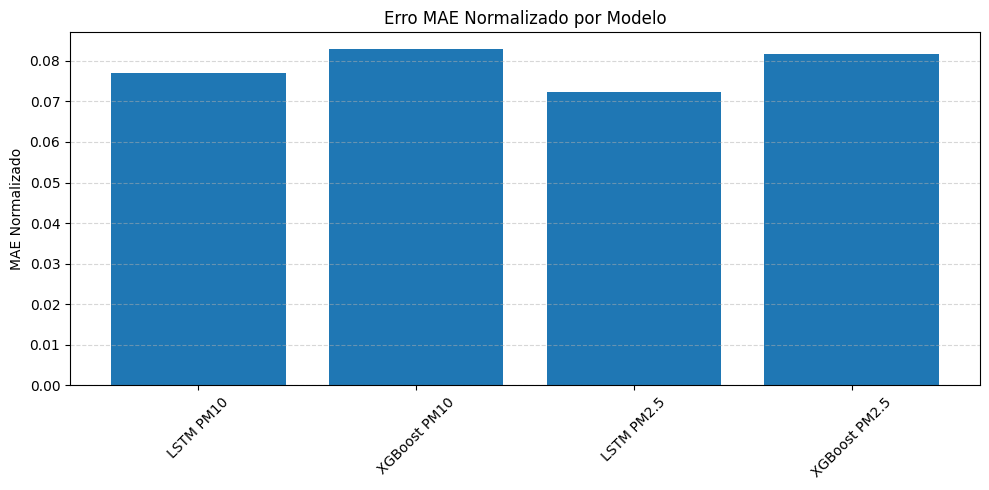

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("metricas_completas.csv")

# =============================================================
# 2) GRÁFICO DE BARRAS — MAE NORMALIZADO
# =============================================================
plt.figure(figsize=(10,5))
plt.bar(df["Modelo"], df["MAE_norm"])
plt.title("Erro MAE Normalizado por Modelo")
plt.ylabel("MAE Normalizado")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


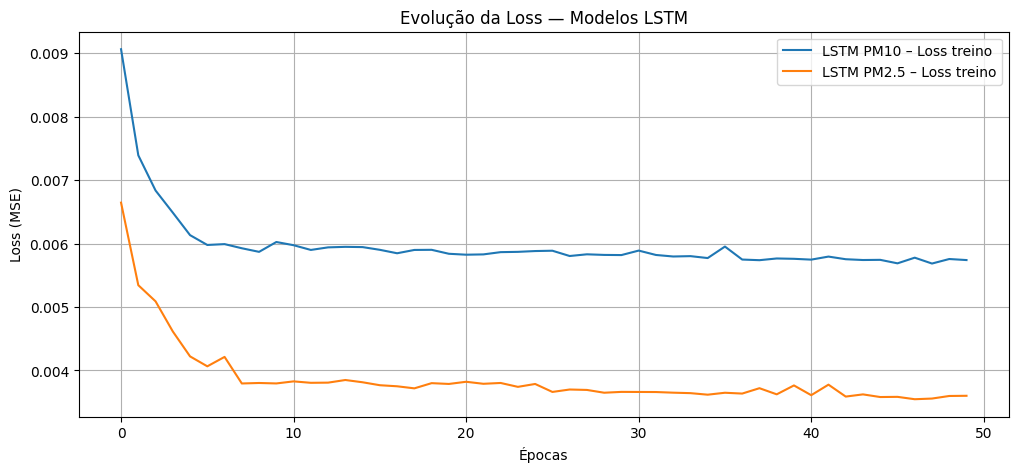

In [ ]:
# =============================================================
# 14. GRÁFICO DA LOSS DO LSTM (PM10 e PM2.5)
# =============================================================

plt.figure(figsize=(12,5))
plt.plot(history_10.history['loss'], label="LSTM PM10 – Loss treino")
plt.plot(history_25.history['loss'], label="LSTM PM2.5 – Loss treino")
plt.title("Evolução da Loss — Modelos LSTM")
plt.xlabel("Épocas")
plt.ylabel("Loss (MSE)")
plt.grid()
plt.legend()
plt.show()